In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet, Lasso
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50
sns.set_style('darkgrid')
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)
%matplotlib inline

In [23]:
train = pd.read_excel("train.xlsx")

In [24]:
def convertTF(df,featureList):
    d = {True:1, False:0}
    for feature in featureList:
        df[feature] = df[feature].apply(lambda x: d[x])
    return df

def yearReturn(x):
    return x.year

def pos(x):
    if x > 0: 
        return 1
    else:
        return 0
def neg(x):
    if x < 0:
        return 1
    else:
        return 0

def val(x):
    if x > 0.44:
        return 3
    elif x < -0.44:
        return 1
    else:
        return 2

def conv_english(x) :
    if x >= 520:
        return 3
    elif x < 420:
        return 1
    else:
        return 2

def conv_logical(x) :
    if x >= 600:
        return 3
    elif x < 450:
        return 1
    else:
        return 2
    
def conv_quant(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def conv_prog(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def gpaCal(x):
    if x <= 10:
        return x*10
    else:
        return x
    
def isNationalBoard(row):
    if (row['isCbse'] or row['isISC'] or row['isICSE']):
        return 1
    else:
        return 0

def prepare(train):
    # Extract Designation
    train['isSenior'] = train.Designation.str.contains('senior')
    train['isSoftware'] = train.Designation.str.contains('software')
    train['isManager'] = train.Designation.str.contains('manager')
    train['isEngineer'] = train.Designation.str.contains('engineer')
    train['isDeveloper'] = train.Designation.str.contains('developer')
    
    # Extract Degree
    train['isBtech'] = train.Degree.str.contains('B.Tech/B.E.')
    train['isMCA'] = train.Degree.str.contains('MCA')
    train['isMtech'] = train.Degree.str.contains('M.Tech./M.E.')
    
    # Extract Board of Examination
    train['isCbse'] = train['12board'].str.contains('cbse')
    train['isStateBoard'] = train['12board'].str.contains('state board')
    train['isISC'] = train['12board'].str.contains('isc')
    train['isICSE'] = train['12board'].str.contains('icse')
    train['isCbse'].fillna(value = False, inplace = True)
    train['isStateBoard'].fillna(value = False, inplace = True)
    train['isISC'].fillna(value = False, inplace = True)
    train['isICSE'].fillna(value = False, inplace = True)
    train['isNationalBoard'] = 0
    train['isNationalBoard'] = train.apply(lambda x : isNationalBoard(x), axis=1)
    
    
    # Extract Specialization
    train['isCSE'] = train.Specialization.str.contains('computer engineering')
    train['isECE'] = train.Specialization.str.contains('electronics and communication engineering')
    train['isIT'] = train.Specialization.str.contains('information technology')
    train['isMech'] = train.Specialization.str.contains('mechanical engineering')
    train['isICE'] = train.Specialization.str.contains('instrumentation and control engineering')
    train['isEE'] = train.Specialization.str.contains('electrical engineering')
    
    train = convertTF(train, ['isCbse', 'isStateBoard', 'isISC', 'isICSE', 'isBtech', 'isMCA', 'isMtech', 'isSenior', 'isSoftware', 'isManager', 'isEngineer', 'isDeveloper','isCSE', 'isECE', 'isIT', 'isMech', 'isICE', 'isEE'])
    
    # Cleaning
    m = train.ComputerProgramming.mean(skipna=True)
    train.ComputerProgramming.fillna(m, inplace=True)

    n = train.Domain.mean(skipna=True)
    train.Domain.fillna(n, inplace=True)

    train.GraduationYear.replace(0,None,inplace=True)
    m = train.GraduationYear.mean(skipna=True)
    train.GraduationYear.fillna(m, inplace=True)
    
    # Generate Features

    #MaxDomain : max of the domains in one column
    train['maxDomain'] = train[['ComputerProgramming','ComputerScience','ElectronicsAndSemicon','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']].max(axis=1)

    # diffGrad : difference between Graduation Year & 12th graduation, to see whether drop in college affect scores
    train['diffGrad'] = train.GraduationYear - train['12graduation']

    # diffGradDOB : difference between Graduation Year and DOB
    train['DOBY'] = train.DOB.apply(yearReturn)
    train['diffGradDOB'] = train.GraduationYear - train.DOBY
    
    # Big Five scores
    train['bigfive'] = 0
    train.bigfive += train.agreeableness.apply(lambda x : val(x))
    train.bigfive += train.conscientiousness.apply(lambda x : val(x))
    train.bigfive += train.nueroticism.apply(lambda x : val(x))
    train.bigfive += train.extraversion.apply(lambda x : val(x))
    train.bigfive += train.openess_to_experience.apply(lambda x : val(x))
    
    # Translate English / Logical / Quants scores
    train['scores'] = 0
    train['scores'] += train.English.apply(lambda x : conv_english(x))
    train['scores'] += train.Logical.apply(lambda x : conv_logical(x))
    train['scores'] += train.Quant.apply(lambda x : conv_quant(x))
    train['scores'] += train.ComputerProgramming.apply(lambda x : conv_prog(x))
    
    # Fix GPA to 100 scale
    train['mcolgGPA'] = train.collegeGPA.apply(lambda x: gpaCal(x))
    
    #Feature columns to take
    feature_cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']
    X = train[feature_cols]
    y = train.Salary
    
    return X,y

In [25]:
X, Y = prepare(train)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state = 1)

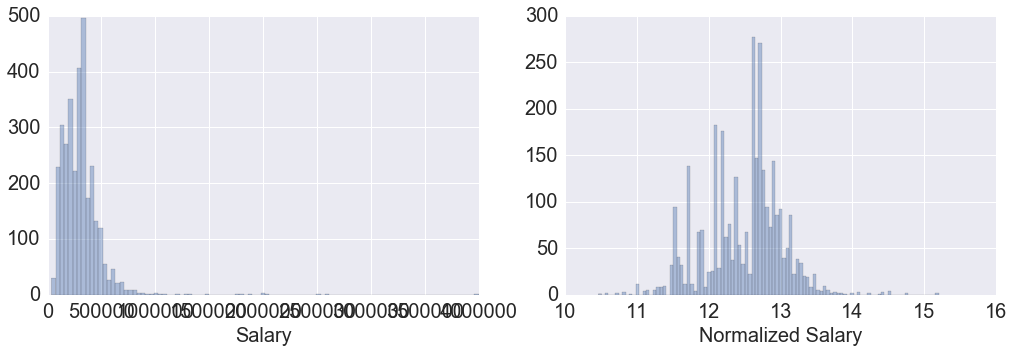

In [27]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(y_train, kde = False, ax = ax1, bins = 100)
sns.distplot(np.log1p(y_train), kde = False, axlabel = 'Normalized Salary', ax = ax2, bins = 100)
#y_train = np.log1p(y_train)

In [29]:
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="mean_squared_error", cv = 5))
    return(cve)
y_train[:3]

train    110000
train    340000
train    300000
Name: Salary, dtype: int64

//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metri

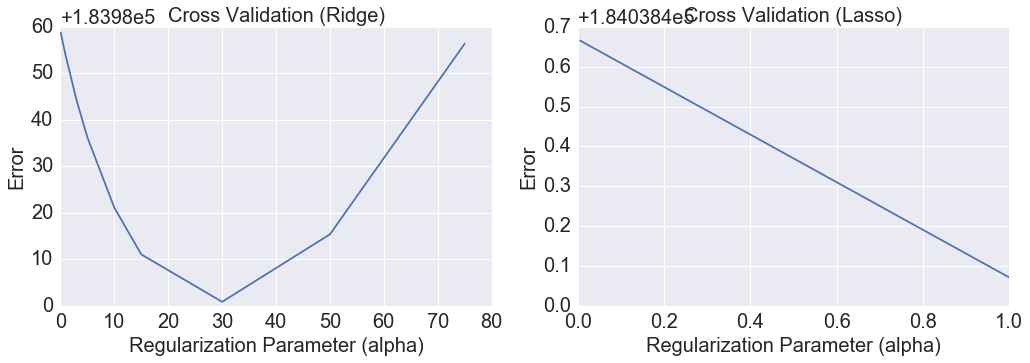

In [30]:
#Ridge
a_ridge = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cvScores_ridge = [cv_error(Ridge(alpha = alpha)).mean() for alpha in a_ridge]
cvScores_ridge = pd.Series(cvScores_ridge, index = a_ridge)
minimum_error = cvScores_ridge.min()

#Lasso
a_lasso = [1, 0.1, 0.02, 0.005]
cvScores_lasso = [cv_error(Lasso(alpha = alpha)).mean() for alpha in a_lasso]
cvScores_lasso = pd.Series(cvScores_lasso, index = a_lasso)
minimum_error_lasso = cvScores_lasso.min()

#Plots
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
ax1.plot(cvScores_ridge)
ax1.set_title("Cross Validation (Ridge)")
ax1.set_xlabel("Regularization Parameter (alpha)")
ax1.set_ylabel("Error")
ax2.plot(cvScores_lasso)
ax2.set_title("Cross Validation (Lasso)")
ax2.set_xlabel("Regularization Parameter (alpha)")
ax2.set_ylabel("Error")

In [31]:
print("Minimum Error for Ridge Model: ", minimum_error)
print("Minimum Error for Lasso Model: ", minimum_error_lasso)

Minimum Error for Ridge Model:  183980.853548
Minimum Error for Lasso Model:  184038.471362


In [37]:
lassoReg = Lasso(alpha=0.01)
lassoReg.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

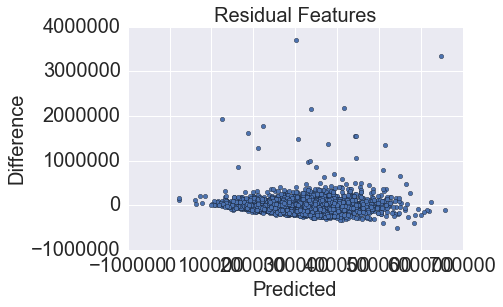

In [38]:
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":lassoReg.predict(X_train), "true":y_train})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")

In [39]:
lassoReg.score(X_train,y_train)

0.17959610749453769

In [48]:
from sklearn.neural_network import MLPRegressor

In [50]:
clf = MLPRegressor(solver = 'lbfgs',random_state= 1)
clf

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)